# EasyVisa

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

In [180]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import datetime as date

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries to split data, impute missing values 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

## Data Overview

- Observations
- Sanity checks

In [134]:
#Loading dataset
data=pd.read_csv("..data/EasyVisa.csv")
data.sample(7, random_state=2)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
18818,EZYV18819,Asia,Master's,Y,N,2939,2005,Midwest,76704.66,Year,Y,Certified
2661,EZYV2662,Africa,Master's,N,N,20199,2005,South,120180.81,Year,N,Denied
11440,EZYV11441,Africa,Master's,Y,N,1213,1998,West,40071.91,Year,Y,Certified
10861,EZYV10862,Asia,Master's,Y,N,603,1994,Northeast,129.35,Hour,Y,Certified
4769,EZYV4770,Asia,Bachelor's,Y,N,2223,1952,South,160635.70,Year,Y,Denied
20524,EZYV20525,Europe,Doctorate,Y,N,1227,1989,Northeast,93891.67,Year,Y,Certified
14631,EZYV14632,Asia,Master's,Y,N,789,2012,Northeast,37197.27,Year,Y,Certified


**Let's take a quick look at the data types and number of rows and columns**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


**Observation**
* There are a total of 25480 rows and 12 columns in the dataset
* None of the columns have null values
* The column names are valid and won't require a clean up
* Our target variable case_status is a categorical variable
* There are 3 numeric columns and 9 categorical columns in the dataset
* case_id is an ID column that will not be useful in building a model or give us any insight. So we will drop the case)id columns from the dataset
* The column yr_of_estab is most likely contains temporal data
* unit_of_wage will help us convert the wage column the same scale/unit 

**Let's drop duplicate rows if exists**

In [135]:
# checking for duplicate values
print('Number of duplicate records in the dataset: ',data.duplicated().sum())

Number of duplicate records in the dataset:  0


**Observation**
* The dataset has no duplicate rows

**We will make a copy of the dataset as to not make any changes to the original data. Also we will transform the object type columns to categorical type to reduce the data space required to store the dataframe**

In [136]:
# copying data to another variable to avoid any changes to original data
df = data.copy()
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


**Let's convert the object type columns into categories**

In [137]:
# As good practice let's convert the object type columns to categorical columns
cols = df.select_dtypes(['object'])
for i in cols.columns:
    df[i] = df[i].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_id                25480 non-null  category
 1   continent              25480 non-null  category
 2   education_of_employee  25480 non-null  category
 3   has_job_experience     25480 non-null  category
 4   requires_job_training  25480 non-null  category
 5   no_of_employees        25480 non-null  int64   
 6   yr_of_estab            25480 non-null  int64   
 7   region_of_employment   25480 non-null  category
 8   prevailing_wage        25480 non-null  float64 
 9   unit_of_wage           25480 non-null  category
 10  full_time_position     25480 non-null  category
 11  case_status            25480 non-null  category
dtypes: category(9), float64(1), int64(2)
memory usage: 2.0 MB


**Summary of the Data Set**

In [138]:
# Print the shape of the dataset
print('Total number of rows in the dataset: ',df.shape[0])
print('Total number of columns in the dataset: ',df.shape[1], '\n')

# Get the total number of unique values for each column
print('Number of unique values per columns: ')
df.nunique()

Total number of rows in the dataset:  25480
Total number of columns in the dataset:  12 

Number of unique values per columns: 


case_id                  25480
continent                    6
education_of_employee        4
has_job_experience           2
requires_job_training        2
no_of_employees           7105
yr_of_estab                199
region_of_employment         5
prevailing_wage          25454
unit_of_wage                 4
full_time_position           2
case_status                  2
dtype: int64

**Observation**
* The dataset has one row per case_id
* Most of the categorical columns do not contain too many unique values

Let's drop the case_id  column before doing further analysis as it is an ID columns and will not provide any helpful insight

In [139]:
#Dropping case_id columns from the dataset
df.drop(columns='case_id',inplace=True)
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


**Now let's check the unique values for all the categorical variables**

In [140]:
#Loop through the categorical variables and print out all the unique values
cols = df.select_dtypes(['category'])
for i in cols.columns:
    print("Unique values in", i, "are :")
    print(df[i].value_counts())
    print("-" * 50)

Unique values in continent are :
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64
--------------------------------------------------
Unique values in education_of_employee are :
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64
--------------------------------------------------
Unique values in has_job_experience are :
Y    14802
N    10678
Name: has_job_experience, dtype: int64
--------------------------------------------------
Unique values in requires_job_training are :
N    22525
Y     2955
Name: requires_job_training, dtype: int64
--------------------------------------------------
Unique values in region_of_employment are :
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: region_of_employment, dtype: int64
-------------------------------------

**Observation**
* Each value assigned for the categorical columns are valid
* For our target variable case_status, we have almost double the number of rows for Certified status than Denied making the dataset imbalanced
* Majority of the candidates are from the region of Asia. Ocenaia region has the least number of candidate
* Majority of the candidates has at least Bachelors degree
* unit_of_wage column has 4 different units, Year, Hour, Week and Month. We will have to further investigate to decide if the prevailing wage column needs any transformation
* full_time_position, requires_job_training, has_job_experience are flags with Y and N as the value

**Let's examine the temporal variable and find the range for the year of establishment for the companies**

In [141]:
#Print the Minimum and Maximum year in the dataset
print('Earliest establishment date :', df['yr_of_estab'].min()) 
print('Latest establishment date :', df['yr_of_estab'].max()) 

Earliest establishment date : 1800
Latest establishment date : 2016


**Observation**
* Dataset contains Visa application for wide variety of companies, some of which are more than 200 year old. And some of which were established as recent as 2016 and are likely in start up phase
* Instead of keeping the year, we could derive the age of the company from the established year and use it in our model

Derive age of the company from the yr_of_estab column

In [142]:
#Let's add a new column company_age that would have the difference between yr_of_estab and current year
df['company_age_year'] = (date.date.today().year - df['yr_of_estab'])

#Let's drop the yr_of_estab column
df.drop(columns='yr_of_estab',inplace=True)
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age_year
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,15
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,20
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,14
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,125
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,17


**Summary Statictics**

In [35]:
# Summary of Datset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27
company_age_year,25480.0,42.590071,42.366929,6.0000,17.00,25.00,46.0000,222.00


**Observation**
* no_of_employees column has a minimum value of -26. Number of employees can not be negative, so we would need to further investigate the data to detect outliers/data issue
* no_of_employees is heavily right skewed with 2109 as the mean and 602069 as the max value
* The mean prevailing_wage has a big range with a minimum of 2.13 to a maximum of 319 K with a mean around 70K. From our previous analysis, we know that some prevailing_wage information is provided in Hourly unit and some in Yearly unit, which explains some of the very low numbers
* company_age_year column has a mean value of 25, 46 at the 75th percentile point and 222 as the maximum value indicating that the data has outliers 

**Clean records with negative employee number**

In [143]:
#Let's check how many records have a negative employee no
print('Number of rows with negative number of employees in the dataset: ',df[df['no_of_employees'] <0].shape[0])

Number of rows with negative number of employees in the dataset:  33


In [144]:
#Let's take the absolute value for all no_of_employees columns in the dataset
df['no_of_employees'] = df['no_of_employees'].abs()
print('Number of rows with negative number of employees remaining in the dataset: ',df[df['no_of_employees'] <0].shape[0])

Number of rows with negative number of employees remaining in the dataset:  0


## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 

2. How does the visa status vary across different continents? 
 
3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 
 
4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 
 
5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

We will start by doing some basic Univariate and Bivariate analysis to understand the data

Let's define the functions we will be using to plot distribution for our analysis

In [78]:
# Function to create labeled distribution plots

def boxplot_histogram(data,feature,figsize=(12,7),kde=False,hue=None,element='bars',bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    hue: Variable that is mapped to determine the color of plot elements
    element:Visual representation of the histogram statistic. Default is bar.
    bins: number of bins for histogram (default None)
    """
    #Set plot settings
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,)  
    # Creating Boxplot
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color='hotpink')  
    # Creating histplot
    if bins:
        sns.histplot(data=data, x=feature, kde=kde,hue=hue,element=element, ax=ax_hist2,bins=bins,color='Indigo')
    else:
        sns.histplot(data=data, x=feature, kde=kde,hue=hue,element=element, ax=ax_hist2,color='Indigo')        
    # Show mean and median in histogram
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")     
    ax_hist2.axvline(data[feature].median(), color="red", linestyle="-")

In [80]:
# function to create labeled barplots


def labeled_barplot(data, feature, show_percent=False, top_n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    show_percent: whether to display percentages instead of count (default is False)
    top_n: displays the top n category levels (default is None, i.e., display all levels)
    """
    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if top_n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(top_n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(data=data,x=feature,palette="Paired",order=data[feature].value_counts().index[:top_n].sort_values(),)

    for p in ax.patches:
        if show_percent == True:
            label = "{:.3f}%".format(100 * p.get_height() / total)  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category
        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(label,(x, y),ha="center",va="center",size=12,xytext=(0, 5),textcoords="offset points",)  # annotate the percentage

    plt.show()  # show the plot

In [79]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

**Let's plot each variable to gain better insight into the distribution of each**

We will plot each variables to help us gain the best insight they provide. We will start with true continous variables and moving onto the categorical variables.

### Univariate Analysis

#### Observation on `no_of_employees`

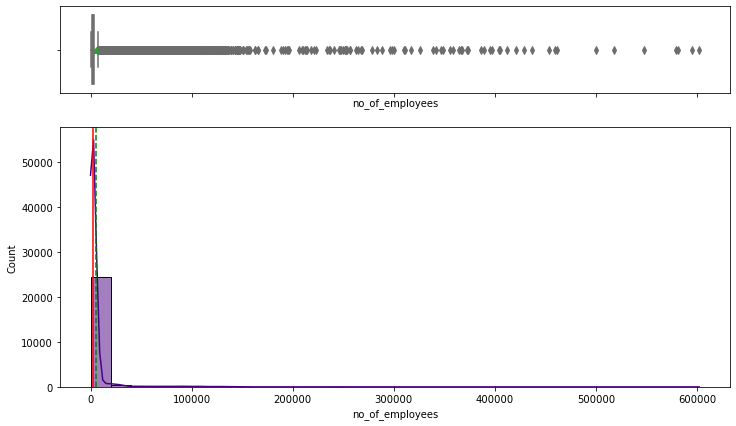

In [81]:
#Plot distribution of the no of employees
boxplot_histogram(df,'no_of_employees',kde=True,bins = 30)

**Observation**
* no_of_employees contains outliers. We will need to do further analyze the data to undestand if the outliers are valid values

#### Observation on `prevailing_wage`

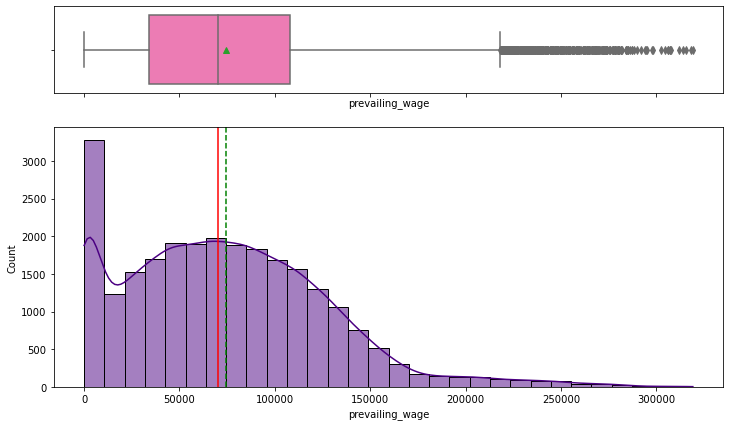

In [41]:
#Plot distribution of the no of employees
boxplot_histogram(df,'prevailing_wage',kde=True,bins = 30)

**Observation**
* The data is right skewed and has outliers on the right. We will have to do further analysis to understand if the values are valid

#### Observation on `company_age_year`

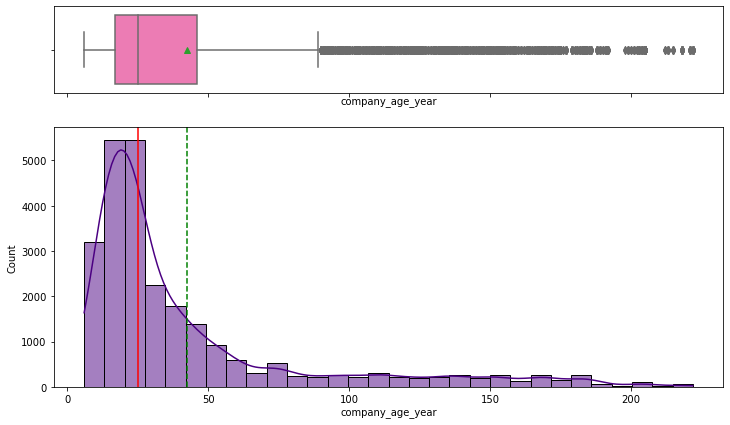

In [42]:
#Plot distribution of the no of employees
boxplot_histogram(df,'company_age_year',kde=True,bins = 30)

**Observation**
* Data is right skewed and has outliers on the right. We will need to do further analysis to understand if the outliers are valid values

#### Observation on `continent`

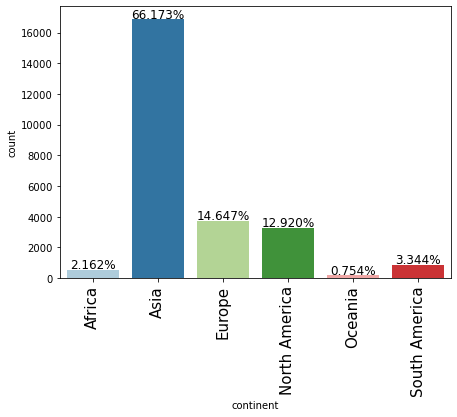

In [43]:
# Let's generate a bar plot for the continent
labeled_barplot(df, 'continent', show_percent=True)

**Observation**
* Majority of the candidates are from Asia, followed by Europe and rest of the North America

#### Observation on `education_of_employee`

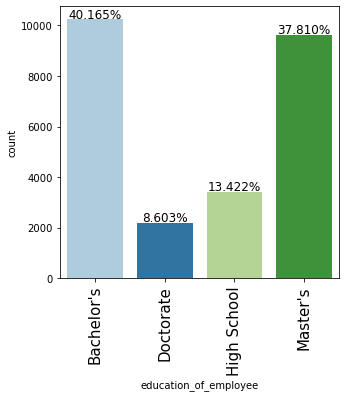

In [44]:
# Let's generate a bar plot for the education_of_employee
labeled_barplot(df, 'education_of_employee', show_percent=True)

**Observation**
* 40% candidates has at least Bachelor's degree, followed by 37.8% candidate with a Master's degree

#### Observation on `has_job_experience`

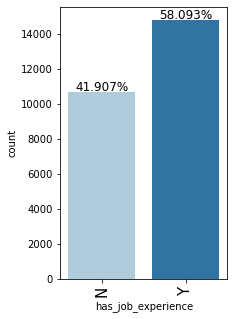

In [46]:
# Let's generate a bar plot for the has_job_experience
labeled_barplot(df, 'has_job_experience', show_percent=True)

**Observation**
* 58% of the candidates have previous job experience

#### Observation on `requires_job_training`

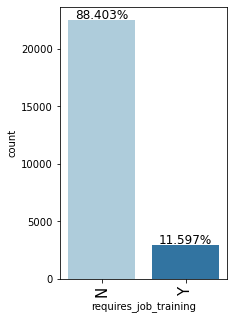

In [47]:
# Let's generate a bar plot for the requires_job_training
labeled_barplot(df, 'requires_job_training', show_percent=True)

**Observation**
* 88% of the candidates do not require job training

#### Observation on `region_of_employment`

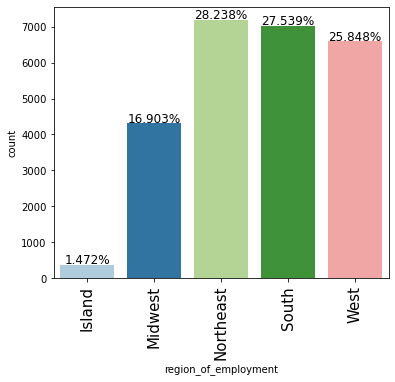

In [48]:
# Let's generate a bar plot for the region_of_employment
labeled_barplot(df, 'region_of_employment', show_percent=True)

**Observation**
* Majority of the candidate are on demand in the Northeast region, with 28.23% of the candidates intending to work in that area, followed by 27.5% intended for the South

#### Observation on `unit_of_wage`

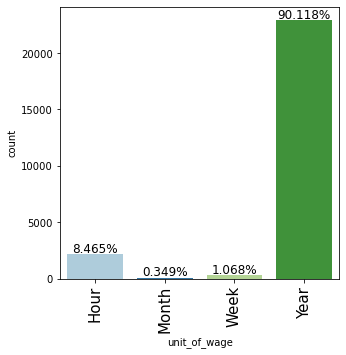

In [49]:
# Let's generate a bar plot for the unit_of_wage
labeled_barplot(df, 'unit_of_wage', show_percent=True)

**Observation**
* Majority of the prevailing wage information has been provided in an yearly format

#### Observation on `full_time_position`

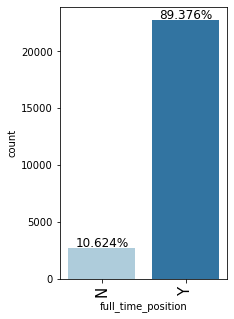

In [50]:
# Let's generate a bar plot for the full_time_position
labeled_barplot(df, 'full_time_position', show_percent=True)

**Observation**
* 89% of the candidates have applied for Full time positions

#### Observation on `case_status`

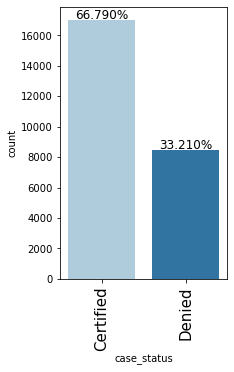

In [51]:
# Let's generate a bar plot for the case_status
labeled_barplot(df, 'case_status', show_percent=True)

**Observation**
* 66.7% percent of the Application were accepted with one third of the applicaiton being denied. This is our target variable and the data is imbalanced

### Bivariate Analysis
We will start with a heat map to find possible correlation between the continous variables

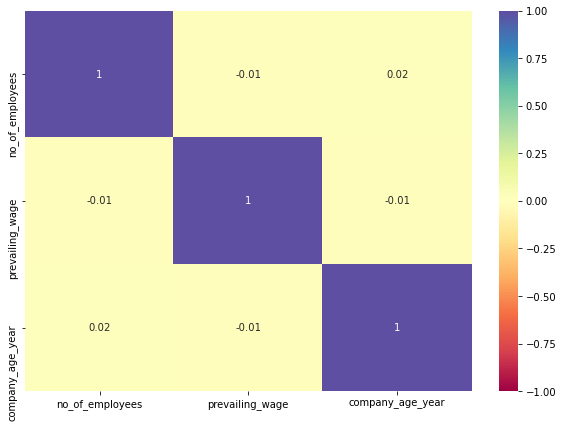

In [52]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.1g',cmap="Spectral")
plt.show()

* None of the continous variables show any significant correlation
* prevailing_wage has a negative relationship with both company_age and no_of_employees columns. It's hard to derive much insight from it as prevailing wage data comes in different untis. It is possible that companies that has been around for a while and big companies with high number of employees also try to get foreign workers for their hourly employee population

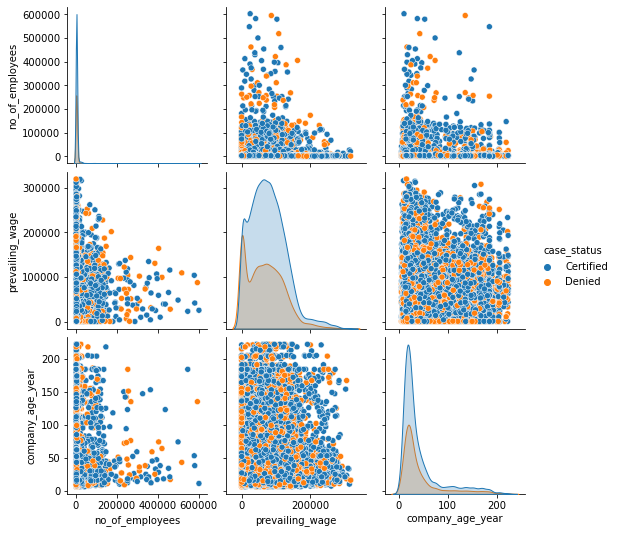

In [54]:
#Let's generate a pair plot for the continous variables to see how they behave for the Certified and Denied applications
sns.pairplot(df,hue='case_status')
plt.show()

* The pair plot doesn't provide much insight as none of the plits has any obvious shape that stands out
* There is overlap in the distribution of variables for both classes. Let's explore this further using other plots.

**Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification?**

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


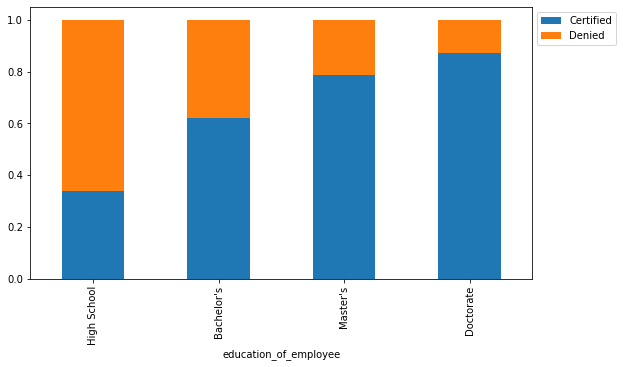

In [58]:
# Let's generate a bar plot for education of employee vs the case_status  
stacked_barplot(df, "education_of_employee", "case_status")

**Observation**
* The plot clearly shows there is a strong relationship between the level of education and the possibility of visa application being accepted. The higher the education level is, the application has a greater chance of being accepted. 
* Almost 90% of the application for a candidate with Doctorate is accepted, followed by almost 80% applications for candidates with a Masters degree

**How does the visa status vary across different continents?**

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


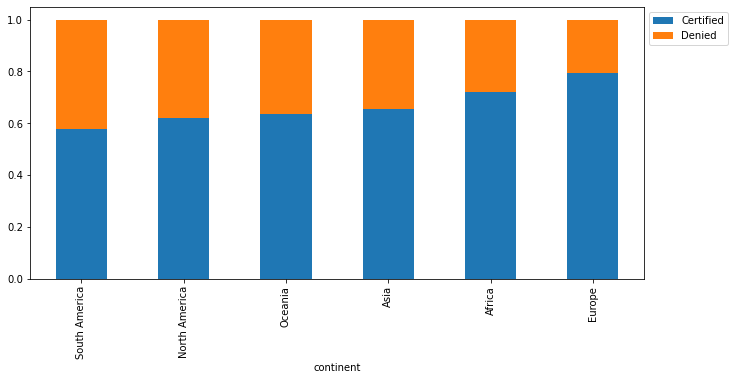

In [55]:
# Let's generate a bar plot for continent of the employee vs the case_status  
stacked_barplot(df, "continent", "case_status")

**Observation**
* From the plot we see, there is a clear relationship between case status and the candidate's continent. Highest number of application are accepted from Asia. However, Asia also has the highest number of application
* Applications from Europe has the highest chance of being accepted with almost 80% of the applications being accept, followed by Africa around 70%

**Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status?**

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


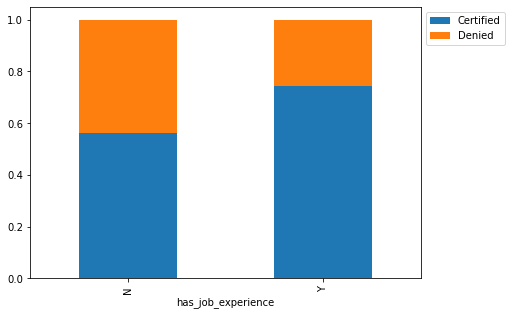

In [56]:
# Let's generate a bar plot for job experience vs the case_status  
stacked_barplot(df, "has_job_experience", "case_status")

**Observation**
* Candidates with Job experience has a higher chance of their Visa application getting approved as opposed to inexperienced candidates

**Do the previous job experience mean the employee do not require job training ?**

has_job_experience         N      Y    All
requires_job_training                     
All                    10678  14802  25480
N                       8988  13537  22525
Y                       1690   1265   2955
------------------------------------------------------------------------------------------------------------------------


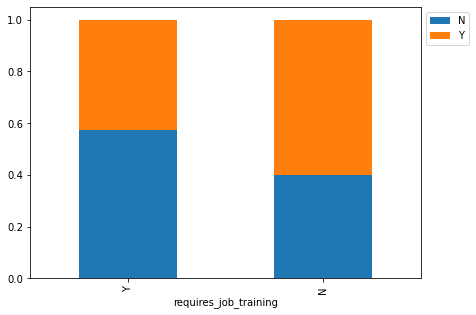

In [82]:
# Let's generate a bar plot for education of employee vs the case_status  
stacked_barplot(df, "requires_job_training", "has_job_experience")

**Observation**
* Slightly more than 40% of the candidate with previous job experience requires job training as opposed to around 55% of the employees with no prior experience requiring training
* Even though there is a difference in percentage, but it is not as significant

**In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa?**

case_status   Certified  Denied    All
unit_of_wage                          
All               17018    8462  25480
Year              16047    6915  22962
Hour                747    1410   2157
Week                169     103    272
Month                55      34     89
------------------------------------------------------------------------------------------------------------------------


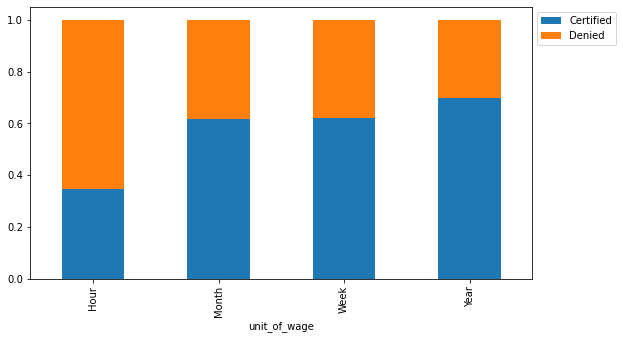

In [57]:
# Let's generate a bar plot for wage unit vs wage
stacked_barplot(df, "unit_of_wage", "case_status")

**Observation**
* There is an obvious relationship between case status and unit of wage
* Employees applying for jobs with hourly pay has the least chance of their visa application being accepted. The application with Yearly wage has the highest chance of being accepted. Rest of the two wage unit has similar chance of being accepted.
* As the hour unit is providing us with valuable information, we will not transform the prevailing_wage column to be all in the same unit as we would like to provide this curcial piece of information to the algorithm

**The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?**

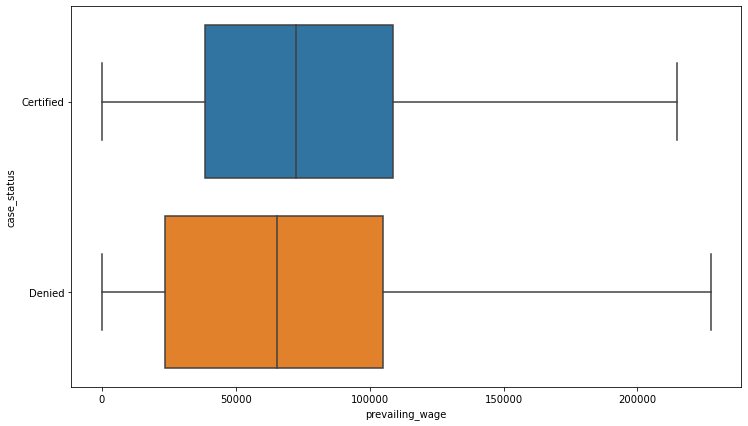

In [58]:
# lets see how prevailing wage varies accross different regions
plt.figure(figsize=(12, 7))
sns.boxplot(x="prevailing_wage", y='case_status', data=df, showfliers=False)
plt.show()

**Observation**
* The range of wage doesn't vary much across cases status, with the median salary being very close. Though the application denied has a higher max amount than accepted

**How does prevailing wage vary accross regions of employment ?**

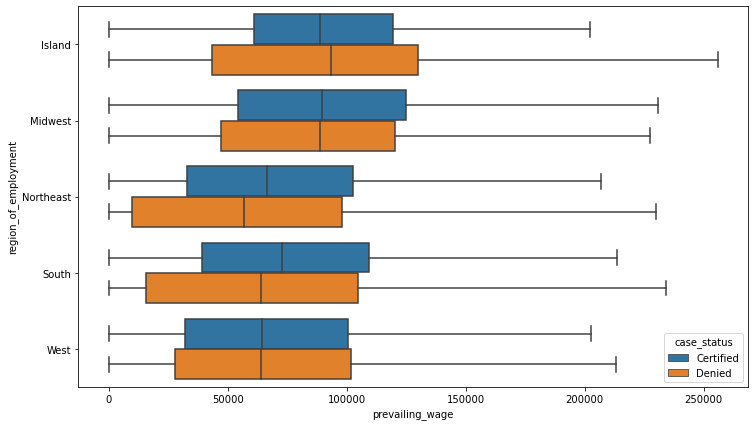

In [69]:
# lets see how prevailing wage varies accross different regions
plt.figure(figsize=(12, 7))
sns.boxplot(y="region_of_employment", x="prevailing_wage", hue='case_status', data=df, showfliers=False)
plt.show()

**Observations**
* The Island has a higher average of prevailing_wage for declined applications than Certified ones. The Maximum wage of declined application far sarpuss the maximum wage for the Certified Visas
* In Most regions, Declined applications has a higher maximum wage than Accepted applications

**Case status accross different region of employment**

case_status           Certified  Denied    All
region_of_employment                          
All                       17018    8462  25480
Northeast                  4526    2669   7195
West                       4100    2486   6586
South                      4913    2104   7017
Midwest                    3253    1054   4307
Island                      226     149    375
------------------------------------------------------------------------------------------------------------------------


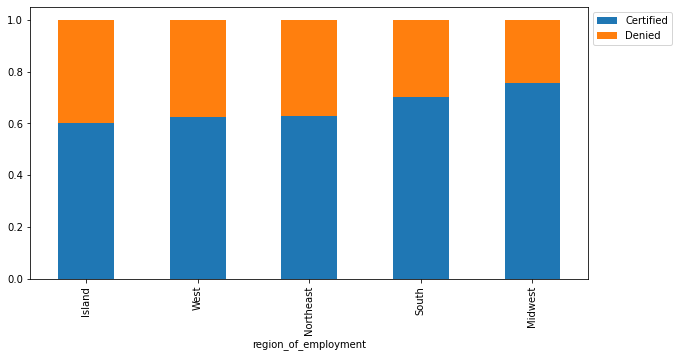

In [84]:
# Let's generate a bar plot for region vs case status
stacked_barplot(df, "region_of_employment", "case_status")

**Observation**
* Midwest region has the highest percentage of Visa applications being accepted, followed by South. The rate of application being accepted for the rest of the regions are almost same

## Data Preprocessing

- Missing value treatment : From our previous analysis, we observed that the dataset has no missing values
- Feature engineering : We have all the columns we need for the modeling. 
        * We derived age of company information from the year of established
        * We have decided to not transform the prevailing wage column to be all in the same unit as the application status seems to depend heavily on the unit of wage
- Outlier detection and treatment : From our EDA we noticed the continous variavles all have outliers. We will go over the columns with outlier again before making a final decision
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

### Outlier detection and treatmen

In [145]:
# Get a list of all numerical columns
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
numerical_col

['no_of_employees', 'prevailing_wage', 'company_age_year']

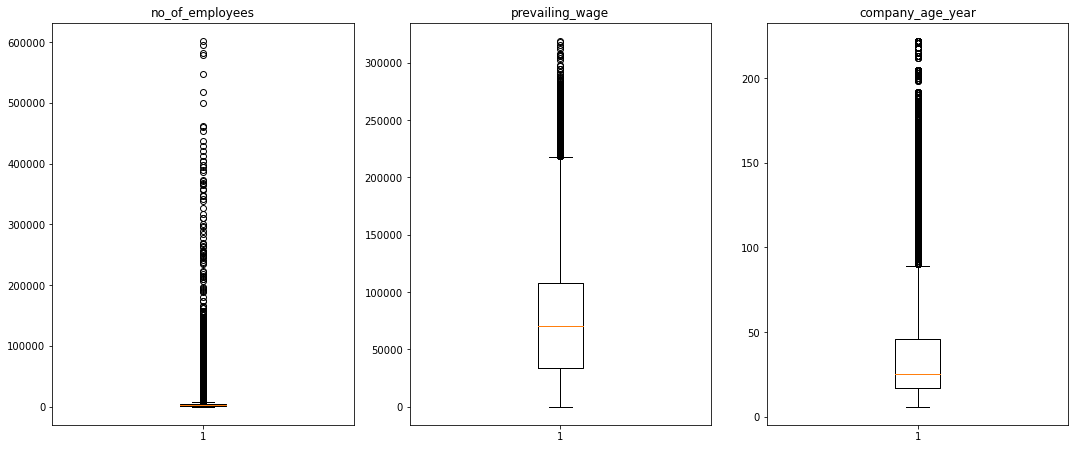

In [146]:
# let's look at box plots for the selected numerical columns to see which columns have outliers
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

All 3 numerical columns in the dataset have outliers.
  * We found some negative values for no of employees during our initial Data check and have already cleaned the data to take the absolute values
  * Based on the type of information these columns are providing, all three continuous variables seem to contain valid values. Which is why we will not be doing any further outlier treatments

### Preparing data for modeling
Convert target variable case_status to 1 and 0. **Certified Case_status will be mapped to 1 where the Denied status will be mapped to 0**

In [147]:
#Map case status to 1 and Not_Cancelled status to 0 for the Booking status column
df["case_status"] = df["case_status"].apply(lambda x: 1 if x == 'Certified' else 0).astype('int64')
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age_year
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,0,15
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,1,20
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,0,14
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,0,125
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,1,17


* We will also need to get dummy variables for all of our categorical columns. We will apply that logic once the data has been split between training and testing. 

## EDA

- It is a good idea to explore the data once again after manipulating it.

Numerical columns in the dataset:  ['no_of_employees', 'prevailing_wage', 'case_status', 'company_age_year']


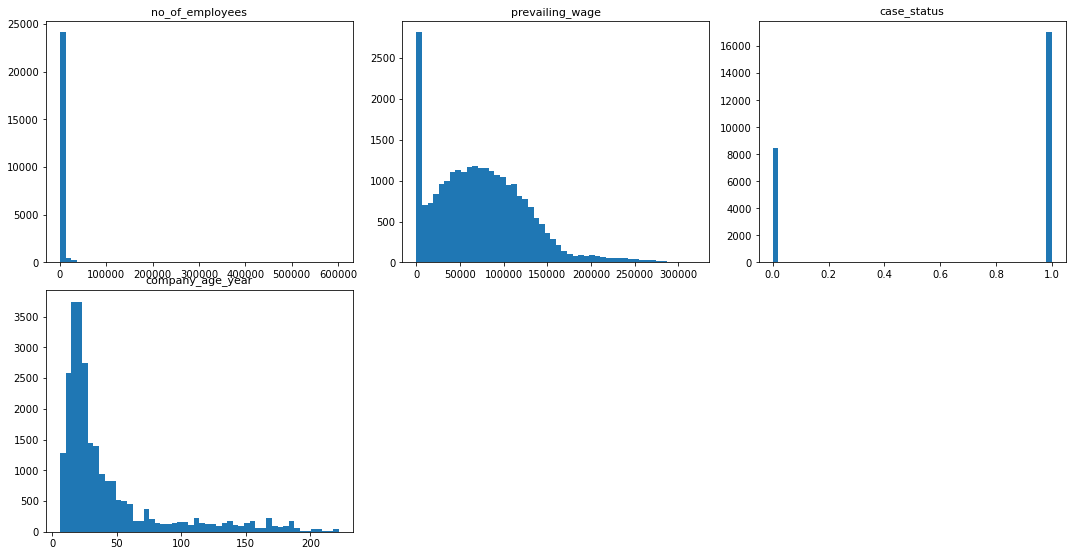

In [160]:
# Get a list of all numerical columns
dist_cols = df.select_dtypes(include=np.number).columns.tolist()
print('Numerical columns in the dataset: ',dist_cols)

# let's plot a histogram of all numerical columns
plt.figure(figsize=(15, 45))

for i in range(len(dist_cols)):
    plt.subplot(12, 3, i + 1)
    plt.hist(df[dist_cols[i]], bins=50)
    plt.tight_layout()
    plt.title(dist_cols[i], fontsize=11)

plt.show()

**Observation**
* Our distributions of continous variables remains the same as before
* Majority of the applications are not from companies with very high number of employees. Very few applications are from companies with high count of employees.
* prevailing wage has a large number of applications on the lower end. But rest of it has a distribution closer to normal
* Distribution of company age is right skewed
* As we mapped case_status to numeric as a prepartion for building the models, we can see the imbalance in data in the distribution with 2/3 of the application having a case status that was accepted

Categorical columns in the dataset:  ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


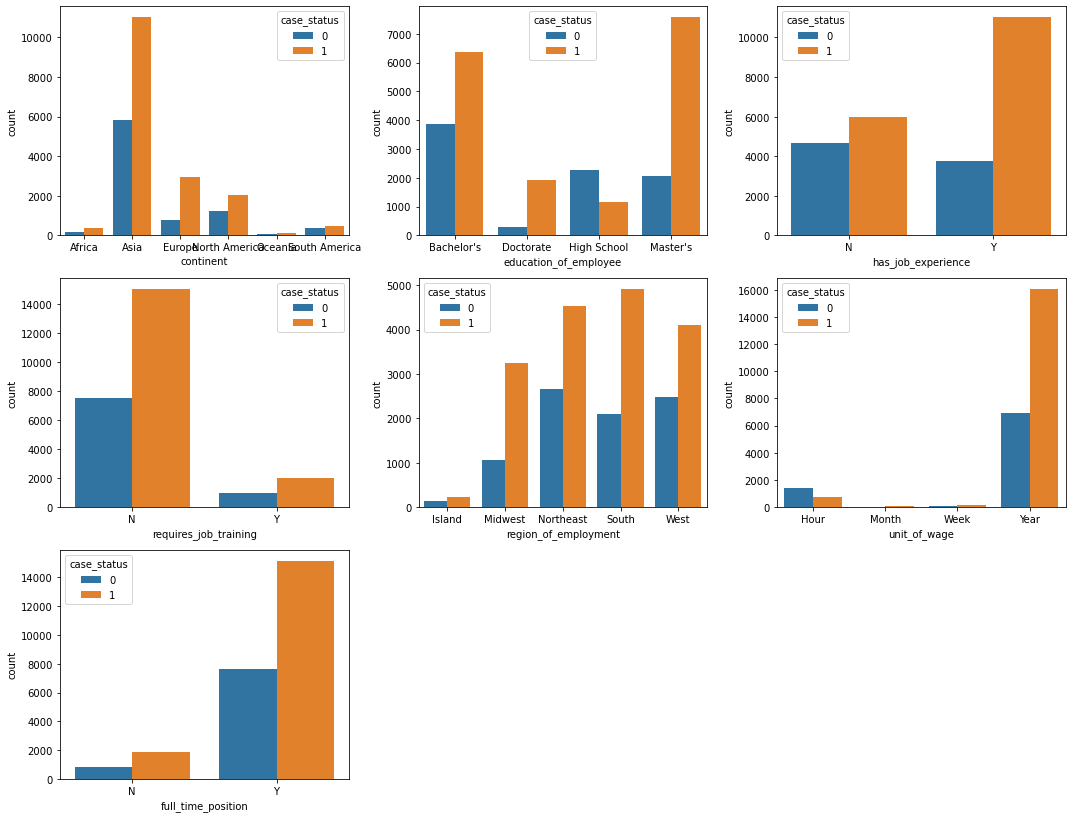

In [159]:
# creating a list of categorical columns
cat_cols = df.select_dtypes(['category']).columns.tolist()
print('Categorical columns in the dataset: ',cat_cols)

# let's plot a histogram of all categorical columns

plt.figure(figsize=(15, 45))
i = 0
for i in range(len(cat_cols)):
    plt.subplot(12, 3, i + 1)
    sns.countplot(df[cat_cols[i]],hue=df['case_status'])
    plt.tight_layout()

plt.show()

**Observation**
* The distribution still remains the same for all the categorical columns
* We see most significant disparity when it comes to visa application approval based on Employee Education Level, Continent of the applicant and the Unit of Wage

## Summary of EDA

##### **Data Description:**

* Dependent variable is the case_status which is of categorical data type with two unique values: Certified and Denied
* Dataset comes with a 3 numerical variables, one of which is temporal information
* There are 9 categorical variables and number of unique values were from 2 to 5, keeping the dimension of the dataset less complex
* There are no missing values or duplicate rows in the dataset

**Data Cleaning:**

* We dropped the case_id column as it's an ID column and doesn't provide us with any helpful insight
* no_of_employees column had some negative values. We cleaned the column to make sure it only has absolute values
* The prevailing_wage data was provided in different units. However, we saw a strong relationship between unit of wage and the case status. Therefore decided to keep the prevailing_wage as is, so that we can derive insight on the effect of different employment type (hourly/anual salary)
* Rest of the data didn't require much cleaning. Most of the columns had categorical data. The outlier values were valid and categorical values had enough information to provide us with possible insights 

**Observations from EDA:**

* `case_status`: case status is our target variable and the dataset comes with 1/3 of the records with a Denied case status and 2/3 with a Certified case status
* `continent` : There was a strong relationship between the candidate's continent and the chance of visa application being certified. Also 90% of the application for European candidate was approved as opposed to less than 60% of the application from South American candidates
* `education_of_employee`: Education level had the most obvious effect on the case status. The higher the education level is, the higher the chances of visa application getting approved with almost 90% candidates with a Doctorate degree getting their Visa approved
* `has_job_experience`: We do see some candidates with previous job experience having a higher chance of getting their visa application getting approved
* `requires_job_training`: Candidates who doesn't require job training does have a higher chance of getting their visa approved. Though the difference is not significant
* `no_of_employees` and `yr_of_estab` : Companies trying to get foreign workers varies greatly in terms of both size and experience. Majority of the companies trying to get foreign worker has an employee population on the lower end, though there are some exceptions with really high employee numbers. Some companies were established over 200 years ago as opposed more new startups established as early as 2016
* `region_of_employment`: Application for jobs in the MidWest has a higher chance of being approved
* `prevailing_wage` and `unit_of_wage` and `full_time_position` : The dataset comes with prevailing_wage information for both annyal salaried and hourly job. Hourly job has a big impact on the case status as below 40% of the visa application for hourly jobs get an approval. Similarly, application for Full time positions has a higher chance of getting approval

## Building bagging and boosting models

## Split Data
* When classification problems exhibit a significant imbalance in the distribution of the target classes, it is good to use stratified sampling to ensure that relative class frequencies are approximately preserved in train and test sets. 
* This is done using the `stratify` parameter in the train_test_split function.

In [161]:
X = df.drop(['case_status'],axis=1)
y = df['case_status']

X = pd.get_dummies(X,drop_first=True)

# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)

In [162]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17836, 21)
Shape of test set :  (7644, 21)
Percentage of classes in training set:
1    0.667919
0    0.332081
Name: case_status, dtype: float64
Percentage of classes in test set:
1    0.667844
0    0.332156
Name: case_status, dtype: float64


## Model evaluation criterion

### The model can make wrong predictions as:
1. Predicting a Visa application will be approved, but in reality it gets denied
2. Predicting a Visa application will be denied, but in reality it gets certified

### Which case is more important? 
1. If the model predicts a Visa application has to be certified but in reality it should be denied, an internal US citizen will miss out on the job opportunity 
2. If the model predicts a Visa application has to be denied but in reality it should be certified, US will miss out on a valuable human resource that would have contibuted to their economy
3. Both cases are equally important as both would result in a loss of opportunity

### Which metric to optimize?
* We would want F1-Score to be maximized, the greater the F1-Score higher the chances of predicting both the classes correctly. 
* From our EDA, we know that the dataset is imbalanced. We will use balanced weights in our model to give both classes importance

**Let's define function to provide metric scores(accuracy,recall, precision and F1) on train and test set and a function to show confusion matrix so that we do not have use the same code repetitively while evaluating models.**

In [96]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [97]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Decision Tree Classifier

In [98]:
#Fitting the model
d_tree = DecisionTreeClassifier(class_weight="balanced",random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)


Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.652015  0.745348   0.736689  0.740993


Confusion metrics : Training set


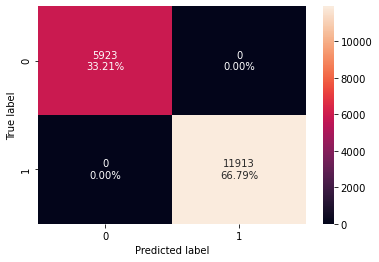

In [99]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(d_tree,X_train,y_train)

Confusion metrics : Testing set


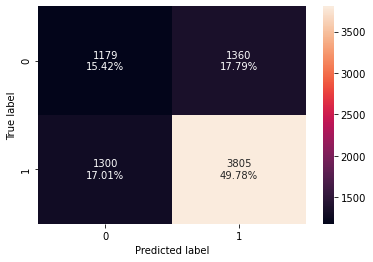

In [100]:
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(d_tree,X_test,y_test)

* The decision tree is clearly overfitting the training data.
* The numbers on the test data is not very good. Also, there is a big difference between the Training and Test metrics

## Random Forest Classifier

In [101]:
#Fitting the model
rf_estimator = RandomForestClassifier(class_weight="balanced",random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.722527  0.841136   0.766238  0.801942


Confusion metrics : Training set


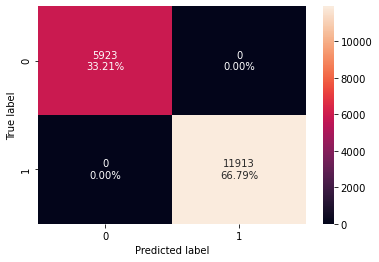

In [102]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(rf_estimator,X_train,y_train)

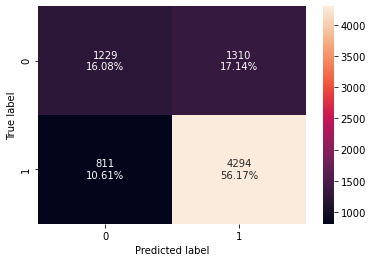

In [103]:
#Creating confusion matrix for the testing data
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* Training data is clearly over fitting in this case as well
* Random forest is giving slightly bettervalues for all 4 metrics compared to Decission tree


## Bagging Classifier

In [104]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)


   Accuracy    Recall  Precision        F1
0  0.985198  0.986066   0.991726  0.988888
   Accuracy    Recall  Precision       F1
0  0.694662  0.765916   0.774411  0.77014


Confusion metrics : Training set


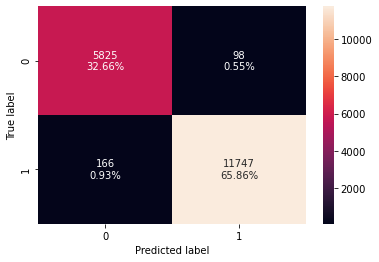

In [105]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(bagging_classifier,X_train,y_train)


Confusion metrics : Training set


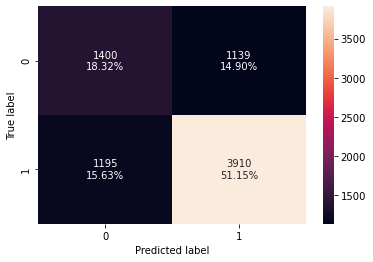

In [106]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)


* Bagging classifier is also overfitting the training data.
* The metrics given by the Baggin Classifier is lower than the Random Forest, but still higher than Decision Tree

## AdaBoost Classifier

   Accuracy    Recall  Precision       F1
0  0.738226  0.887182   0.760688  0.81908
   Accuracy    Recall  Precision        F1
0  0.734301  0.885015   0.757799  0.816481


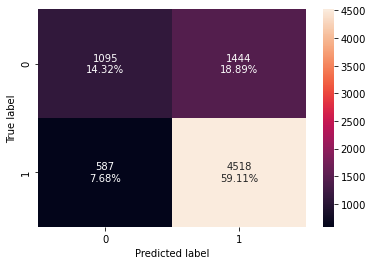

In [107]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* Adaboost is giving similar performance for both Training and Testing data
* All 4 scores went significantly up for AdaBoost Classifier, with an accuracy of .73 and an F1 score of .81

## Gradient Boosting Classifier

In [108]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)


Training performance:
    Accuracy   Recall  Precision        F1
0  0.758802  0.88374   0.783042  0.830349
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.744767  0.876004   0.772366  0.820927


Confusion metrics : Training set


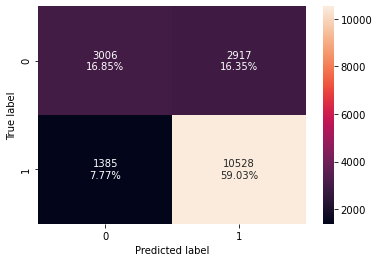

In [109]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(gb_classifier,X_train,y_train)

Confusion metrics : Testing set


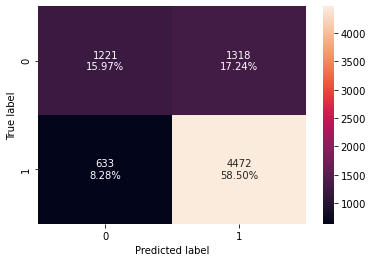

In [110]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* The gradient boosting classifier is also giving a generalized performce, with both training and testing data having similar score for all 4 metrics
* The score also went up for all 4 compared to AdaBoost. So far the best overall performance compared to the previous models

## XGBoost Classifier

In [111]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)


Training performance:
    Accuracy    Recall  Precision        F1
0  0.838753  0.931419   0.843482  0.885272
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.733255  0.860921    0.76782  0.811709


Confusion metrics : Training set


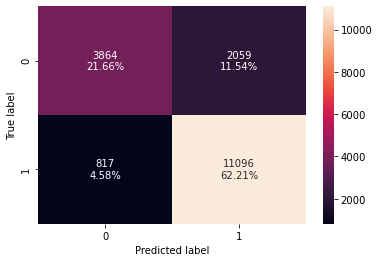

In [112]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(xgb_classifier,X_train,y_train)

Confusion metrics : Testing set


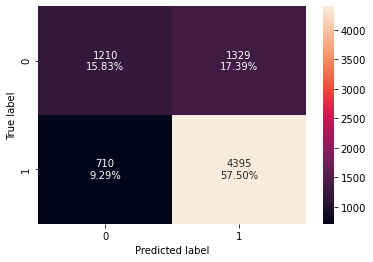

In [113]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* xgboost classifier is overfitting the training data as the performance between training and testing data varies significantly
* Overall performance is also not as good as Gradient Boost 

##  Will tuning the hyperparameters improve the model performance?

We have built the models based on all default parameters. Even though the decision tree and random forest was over fitting on the training data and wasn't necessarily giving us great performance, the AdaBoost and Gradient Boosting classifier provided good performance on both traing and test data. 

However, can we further improve this performance by Hypertuning the parameters ?

## Decision Tree Classifier

### Hyperparameter Tuning

In [114]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight='balanced',random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(10,30,5), 
              'min_samples_leaf': [3, 5 ,7],
              'max_leaf_nodes' : [2, 3, 5],
              'min_impurity_decrease': [0.0001,0.001]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=2,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

In [183]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.712548  0.931923   0.720067  0.812411
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.706567  0.930852   0.715447  0.809058


Confusion metrics : Training set


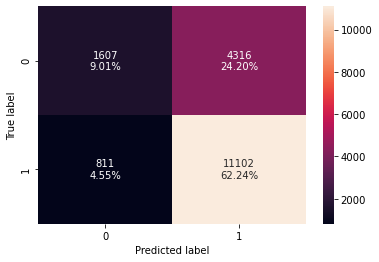

In [184]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(dtree_estimator,X_train,y_train)

Confusion metrics : Testing set


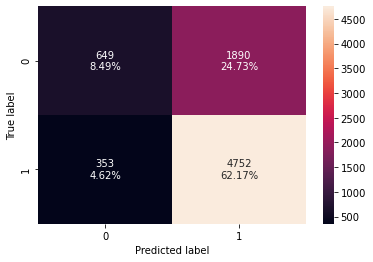

In [185]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

* The model is no longer overfitting on training data.
* The performance score has also significantly improved for all metrics except for precision.

## Random Forest Classifier

### Hyperparameter Tuning

In [125]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight='balanced',random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,15,5)),
                'max_features': ['sqrt','log2'],
                'min_samples_leaf': np.arange(3,5,7),
                'n_estimators': np.arange(10,50,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=3, n_estimators=40,
                       oob_score=True, random_state=1)

In [126]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.759868  0.797196   0.835709  0.815999
Testing performance:
    Accuracy    Recall  Precision      F1
0  0.723836  0.774535    0.80464  0.7893


Confusion metrics : Training set


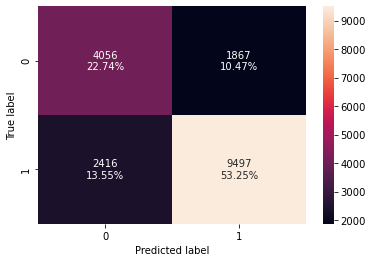

In [127]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(rf_tuned,X_train,y_train)

Confusion metrics : Testing set


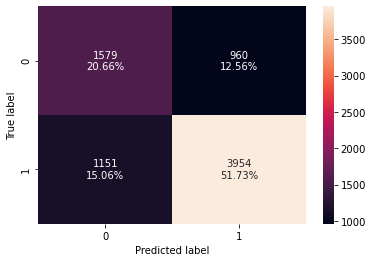

In [128]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

* The overfitting has reduced significantly. However, the model performance has actually decreased after hyperparameter tuning
* The accuracy remained almost the same for Test data. Recall and F1 score went down after tuning. The only score that went up slightly is Precision, going from .76 to .8

## Bagging Classifier

### Hyperparameter Tuning

In [129]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,.9], 
              'max_features': [0.7,0.8,.9],
              'n_estimators' : np.arange(50, 110, 10),
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.7, max_samples=0.8, n_estimators=90,
                  random_state=1)

In [130]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

   Accuracy    Recall  Precision        F1
0  0.998767  0.999832   0.998324  0.999077
   Accuracy    Recall  Precision        F1
0  0.727106  0.893046     0.7475  0.813816


Confusion metrics : Training set


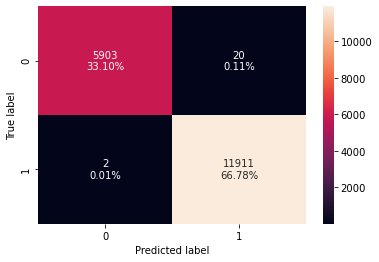

In [163]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(bagging_estimator_tuned,X_train,y_train)

Confusion metrics : Testing set


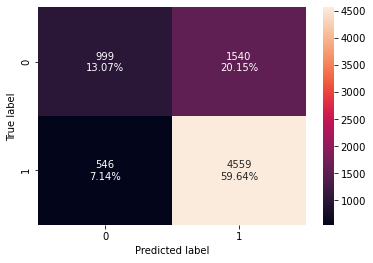

In [164]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* The model is still overfitting on Training data
* But the performance on Test data has increased on all 4 metrics
* We see the most significant jump for Recall score where the score went from .76 to .89 after Hyper Parameter Tuning

## AdaBoost Classifier

### Hyperparameter Tuning

In [186]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=1)
                      ,DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=1)
                      ,DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=1)],
    "n_estimators": np.arange(10,30,10),
    "learning_rate":np.arange(0.1,.4,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=10, random_state=1)

In [187]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

   Accuracy    Recall  Precision        F1
0  0.729199  0.889616   0.750939  0.814416
   Accuracy    Recall  Precision        F1
0  0.723705  0.890304   0.745449  0.811462


Confusion metrics : Training set


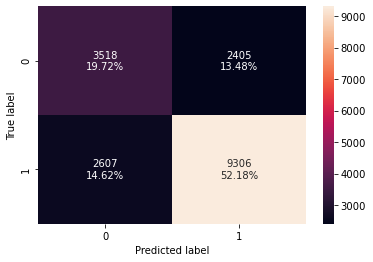

In [167]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(abc_tuned,X_train,y_train)

Confusion metrics : Testing set


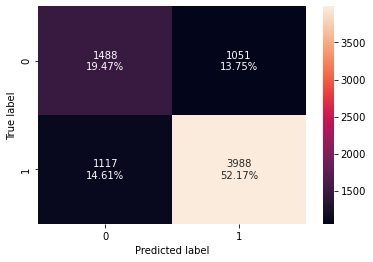

In [168]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

* The model is still giving generalized performance for both training and testing data
* While there was a slight increase in performance for recall, the other three score dropped a little from the default AdaBoost model

## Gradient Boosting Classifier

### Hyperparameter Tuning

In [169]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,300],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,1],
    "learning_rate": np.arange(0.1, 0.4, 0.1)
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.7, random_state=1, subsample=1)

In [170]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

Training performance:
    Accuracy   Recall  Precision        F1
0  0.757961  0.88097    0.78356  0.829415
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.745552  0.874045   0.774115  0.821051


Confusion metrics : Training set


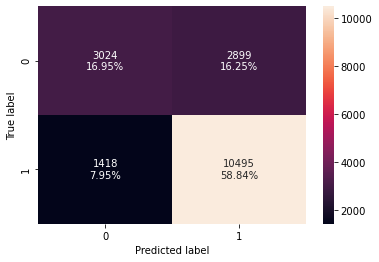

In [171]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(gbc_tuned,X_train,y_train)

Confusion metrics : Testing set


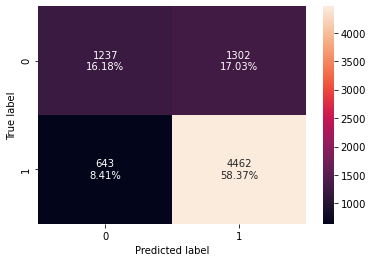

In [172]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* There is not much difference in the model performance after hyperparameter tuning.
* Gradient Boosting is still providing the best overall performance out of all the previous models we have tuned so far

## XGBoost Classifier

### Hyperparameter Tuning

In [188]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30],
    "scale_pos_weight":[1,2],
    "subsample":[0.7,0.9],
    "learning_rate":[0.05, 0.1],
    "colsample_bytree":[0.7,0.9],
    "colsample_bylevel":[0.5,0.7]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [190]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0   0.76497  0.890204   0.786196  0.834974
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.744375  0.875808    0.77206  0.820668


Confusion metrics : Training set


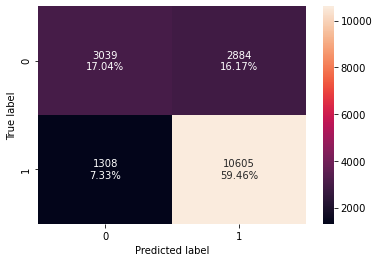

In [191]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(xgb_tuned,X_train,y_train)

Confusion metrics : Testing set


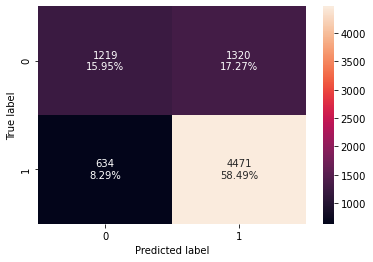

In [192]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* The overfitting has reduced slightly but there is not much difference in the model performance.

## Stacking Classifier

In [193]:
estimators = [('Random Forest',rf_tuned)
              , ('Gradient Boosting',gbc_tuned)
              , ('AdaBoost',ab_classifier)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(estimators=[('Random Forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       max_features='sqrt',
                                                       min_samples_leaf=3,
                                                       n_estimators=40,
                                                       oob_score=True,
                                                       random_state=1)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                           max_features=0.7,
                                                           random_state=1,
                                                           subsample=1)),
                               ('AdaBoost',
            

In [194]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.764241  0.883908   0.788646  0.833564
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.743328  0.870127   0.773733  0.819104


Confusion metrics : Training set


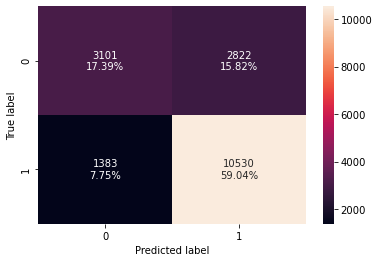

In [195]:
#Creating confusion matrix for the training data
print('Confusion metrics : Training set')
confusion_matrix_sklearn(stacking_classifier,X_train,y_train)

Confusion metrics : Testing set


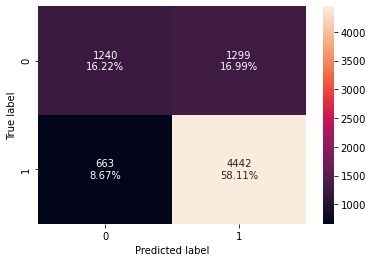

In [196]:
#Creating confusion matrix for the testing data
print('Confusion metrics : Testing set')
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

* Stacking classifier giving generalized performance for both training and testing data
* The performance score is very similar to XGBoost

## Model Performance Comparison and Conclusions

**Training Performance Comparison**

In [197]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.712548,1.0,0.759868,0.985198,0.998767,0.738226,0.729199,0.758802,0.757961,0.838753,0.764970,0.764241
Recall,1.0,0.931923,1.0,0.797196,0.986066,0.999832,0.887182,0.889616,0.883740,0.880970,0.931419,0.890204,0.883908
Precision,1.0,0.720067,1.0,0.835709,0.991726,0.998324,0.760688,0.750939,0.783042,0.783560,0.843482,0.786196,0.788646
F1,1.0,0.812411,1.0,0.815999,0.988888,0.999077,0.819080,0.814416,0.830349,0.829415,0.885272,0.834974,0.833564


**Testing Performance Comparison**

In [198]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.652015,0.706567,0.722527,0.723836,0.694662,0.727106,0.734301,0.723705,0.744767,0.745552,0.733255,0.744375,0.743328
Recall,0.745348,0.930852,0.841136,0.774535,0.765916,0.893046,0.885015,0.890304,0.876004,0.874045,0.860921,0.875808,0.870127
Precision,0.736689,0.715447,0.766238,0.804640,0.774411,0.747500,0.757799,0.745449,0.772366,0.774115,0.767820,0.772060,0.773733
F1,0.740993,0.809058,0.801942,0.789300,0.770140,0.813816,0.816481,0.811462,0.820927,0.821051,0.811709,0.820668,0.819104


**Observation**
* The best performance score are coming from the Gradient Boost Tuned and XGBoost Tuned models. 
* All the tuned models are giving generelized performance while for default models the training model was overfitting except for AdaBoost model
* The tuned Gradient Boost had the best over all score as well as best F1 score which has slightly higher performance scores than XGBoost Model. So we recommend using the Gradient Boost model. 

### Feature importance of Tuned Gradient Boost

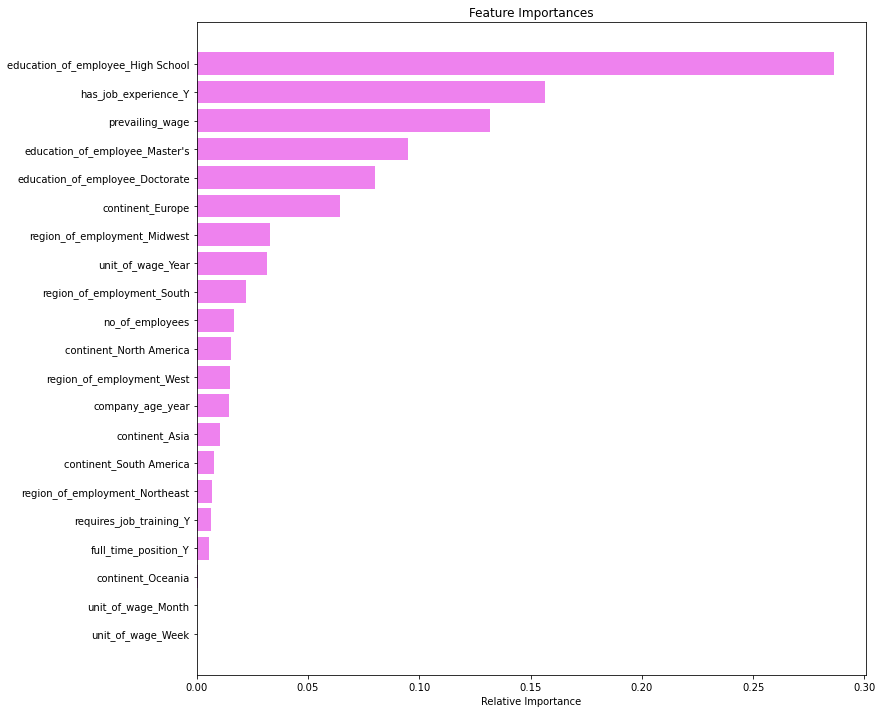

In [201]:
feature_names = X_train.columns
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Observation**
* The most important feature in predicting which Visa application will be Certified seems to be the candidate's level of education
* Candidates's previous Job experience and the prevailing wage plays an important part in making decision as well
* The other three important features are whether employee is from Europe, if the job is from the midwest and employee having a yearly wage

## Actionable Insights and Recommendations

Based on our analysis, it seems the Visa application for positions that requires highly educated, highly skilled candidates has a higher chance of getting approved as opposed to Blue collar positions with hourly wage that can be taken by candidates with High School diploma. We see this reflected in both the EDA performed on the data and the most important features predicted by the model.
 
- We see the preference for highly skilled candidates reflected through the importance of several features indetified by the predictive model. The most important features identified by the model all indicate application for white collar job, such as education level, higher prevailing wage and yearly salary

- From the Predictive model as well as the EDA, we can say that the most important factor that plays into Visa application certification is the candidates education level.
   
   * Candidate's with only High School Diploma has the highest chance of immediately being denied Visa. 
   * Candidate having masters and doctorate degree degree however has a high chance of having their Visa application certified
   * From the EDA we saw almost 90% of the candidates with a doctorate have their Visa application accepted, as opposed to candidates with High school diploma having around 30% approval rate

- Candidates previous Job experience also plays an important factor, though requires job training is at the bottom of the list. From our EDA we know there is no significant relationship between previous job experience and training requirement. As long as the candidate has experience, their chance of getting approval goes up.

- Candaidates from the continent of Europe also has a higher chance of getting their Visa application approved with almost 80% of the Visa application for European candidates are certified

- Lastly Visa application coming for opportunities in the MidWest region has a higher chance of getting certified


### Recomendations
The company can safely put their focus on processing the applications of candidates with higher education level and previous job experience first. They can also add candidates from Europe for short listing.

The data provided shows that the Visa application for highly educated, skilled workers have higher chance of getting approval. However, it doesn't give us a clear picture of what type of job and company these candidates are being considered for. 

If EasyVisa is able to collect additional data regardin the type of jobs and type of company, we might be able to extract more value out of the predictive model and help shortlist the candidates even further.